In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns
import matplotlib.colors as mcolors

from tabulate import tabulate
from numba import prange
from scipy.stats import pearsonr, spearmanr, zscore, chi2_contingency

pd.set_option("display.width", 80)
pd.set_option("display.max_colwidth", None)

In [2]:
# 1. load all data files and pair them as a corpus
data_files = os.listdir("data")
reward_df_files = sorted(
    [f for f in data_files if "scoredreward_humanassistant_includeprompt" in f],
    key=lambda x: x.replace("_ancestral_", "_top_k50_") if "strict" not in x else x,
)
nll_df_files = sorted(
    [f for f in data_files if "scorednll" in f and "includeprompt" not in f],
    key=lambda x: x.replace("_ancestral_", "_top_k50_") if "strict" not in x else x,
)
correction_files = sorted(
    [f for f in data_files if "scoredcorrectionnll" in f],
    key=lambda x: x.replace("_ancestral_", "_top_k50_") if "strict" not in x else x,
)

triplet_files = [
    (r, n, c) for r, n, c in zip(reward_df_files, nll_df_files, correction_files)
]
assert len(reward_df_files) == len(nll_df_files) == len(correction_files)

for r, n, c in triplet_files:
    print()
    print(r)
    print(n)
    print(c)


ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scorednll.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scoredcorrectionnll_ancestral_strict_1.0_humanassistant_includeprompt_conditioned.csv

ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_eta_n00009_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_eta_n00009_t1.0_humanassistant_scorednll.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_eta_n00009_t1.0_humanassistant_scoredcorrectionnll_eta_n00009_1.0_humanassistant_includeprompt_conditioned.csv

ethz-spylab-rlhf-7b-harmless_l256_promptseed4

In [3]:
# 2. set parameters
# 2.1 computations
num_corpuses = 1000
num_samples_per_corpus = 1000
metropolis_steps = 1000
include_nonmetropolis = False

# 2.2 graphics
rejected_colour_filters = [
    lambda x: x != "w" and x != "k",  # no black or white in cmyk
    # no whites, grays or blacks in css colours
    lambda x: x
    not in {
        "snow",
        "ivory",
        "black",
        "seashell",
        "azure",
        "aliceblue",
        "honeydew",
        "oldlace",
        "bisque",
        "blancedalmond",
        "papayawhip",
        "beige",
        "lemonchiffon",
        "linen",
        "moccasin",
        "wheat",
        "peachpuff",
    },
    lambda x: "gray" not in x
    and "grey" not in x
    and "white" not in x
    and "light" not in x
    and "misty" not in x
    and "silk" not in x
    and "mint" not in x
    and "lavendar" not in x
    and "pale" not in x,
]
colours = [
    c
    for c in (
        list(mcolors.BASE_COLORS.keys())
        + list(mcolors.TABLEAU_COLORS.keys())
        + list(mcolors.CSS4_COLORS.keys())
    )
    if all(f(c) for f in rejected_colour_filters)
]

sampling_types_to_names = {
    "ancestral_strict_t1.0": ("Ancestral", colours[0]),
    # "ancestral_strict_t1.5": "t=1.5",
    # "ancestral_strict_t2.0": "Temperature 2.0",
    "ancestral_t1.0": ("Top-k (k=50)", colours[1]),
    "ancestral_t1.5": ("Top-k (k=50, t=1.5)", colours[2]),
    "ancestral_t2.0": ("Top-k (k=50, t=2.0)", colours[3]),
    "eta_n00009_t1.0": ("Eta", colours[4]),
    "eta_n00009_t1.5": ("Eta (t=1.5)", colours[5]),
    "eta_n00009_t2.0": ("Eta (t=2.0)", colours[6]),
    "top_k30_t1.0": ("Top-k (k=30)", colours[7]),
    "top_k30_t1.5": ("Top-k (k=30, t=1.5)", colours[8]),
    "top_k30_t2.0": ("Top-k (k=30, t=2.0)", colours[9]),
    "top_p090_t1.0": ("Top-p (p=0.9)", colours[10]),
    "top_p090_t1.5": ("Top-p (p=0.9, t=1.5)", colours[11]),
    "top_p090_t2.0": ("Top-p (p=0.9, t=2.0)", colours[12]),
    "top_p095_t1.0": ("Top-p (p=0.95)", colours[13]),
    "top_p095_t1.5": ("Top-p (p=0.95, t=1.5)", colours[14]),
    "top_p095_t2.0": ("Top-p (p=0.95, t=2.0)", colours[15]),
    "typical_p090_t1.0": ("Typical", colours[16]),
    "typical_p090_t1.5": ("Typical (t=1.5)", colours[17]),
    "typical_p090_t2.0": ("Typical (t=2.0)", colours[18]),
}
assert len(colours) >= len(triplet_files)
assert len(sampling_types_to_names) == len(triplet_files), (
    len(sampling_types_to_names),
    len(triplet_files),
)



Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scorednll.csv:
Length: 1948
+----+----------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

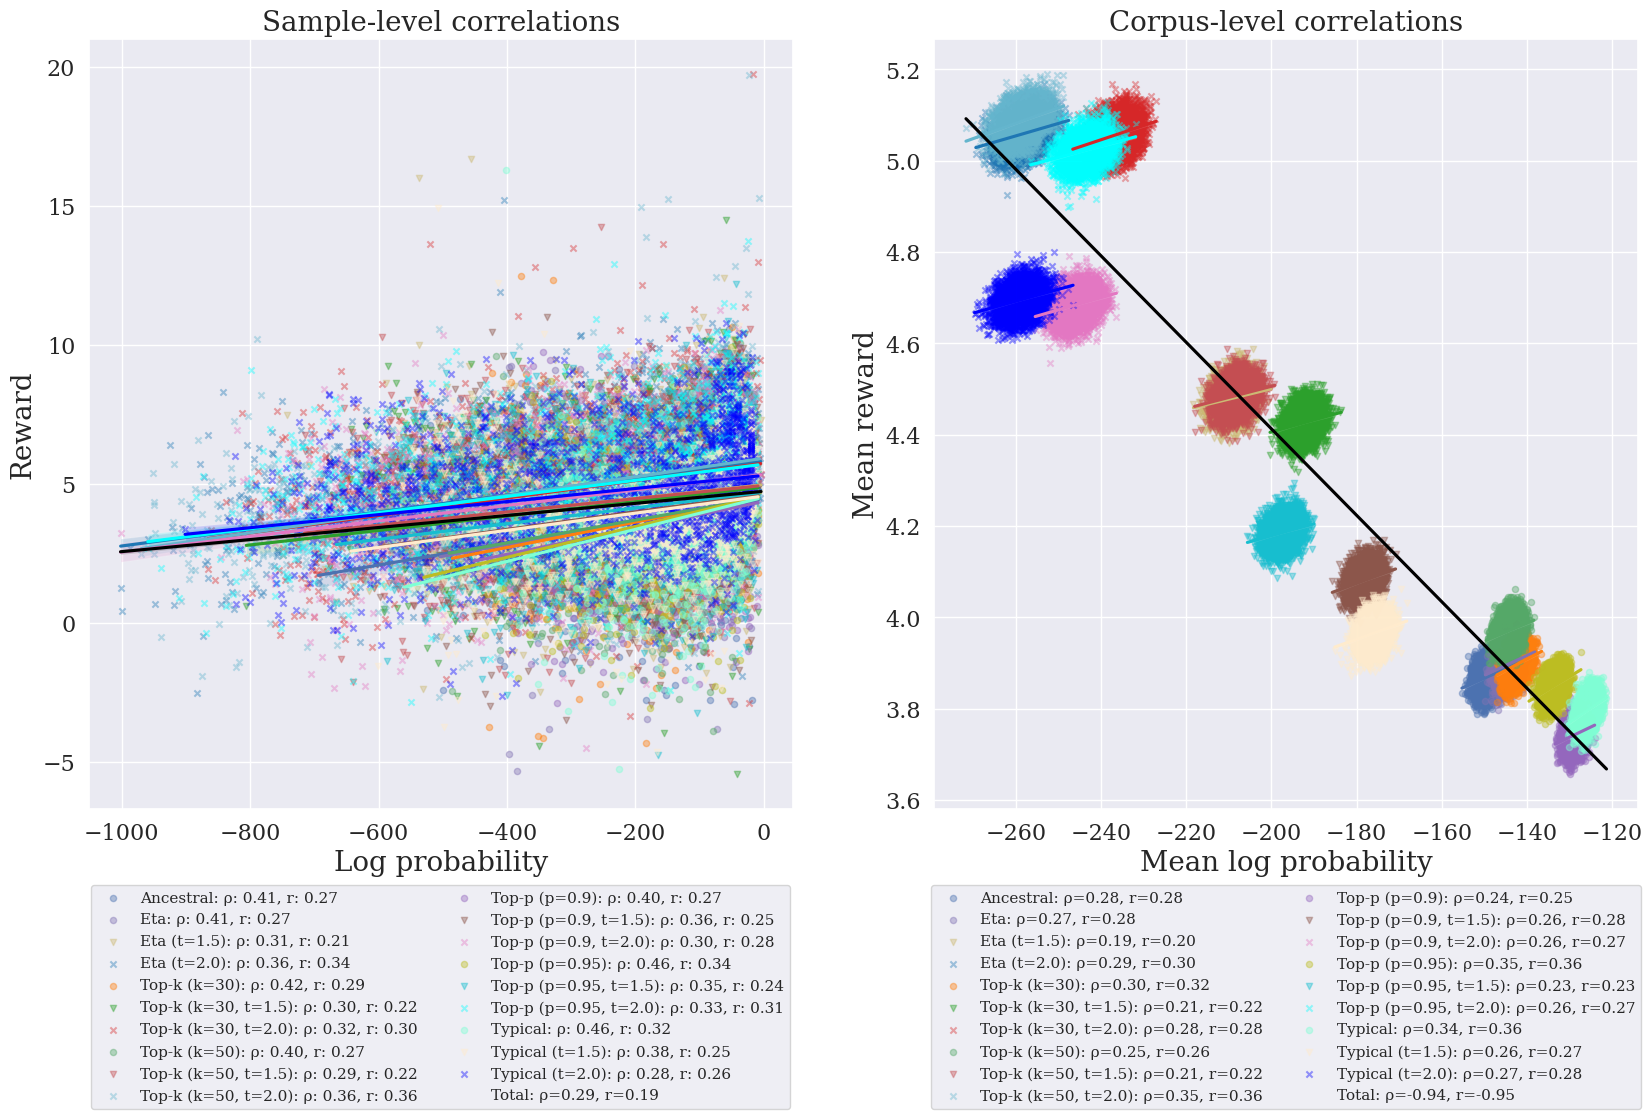

In [8]:
# 3. analysis on each corpus
fig, axs = (
    plt.subplots(1, 3, figsize=(30, 10))
    if include_nonmetropolis
    else plt.subplots(1, 2, figsize=(20, 10))
)
total_mean_corpuses = None
total_corpus = None
total_mean_corrected_corpuses = None
total_mean_metropolis_corpuses = None
acceptance_rates = dict()


for idx, (reward_df_file, nll_df_file, correction_df_file) in enumerate(triplet_files):
    # 3.0 annotation styling
    possible_names = [
        sampling_type
        for sampling_type in sampling_types_to_names.keys()
        if sampling_type in reward_df_file
    ]
    assert len(possible_names) == 1
    sampling_name = possible_names[0]
    assert sampling_name in nll_df_file and sampling_name in correction_df_file
    name = sampling_types_to_names[sampling_name][0]
    marker = "v" if "t1.5" in sampling_name else "x" if "t2.0" in sampling_name else "o"
    colour = sampling_types_to_names[sampling_name][1]

    print(f"\n\nAnalyzing {reward_df_file} and {nll_df_file}:")

    # 3.1 load and merge
    reward_df = pd.read_csv(f"data/{reward_df_file}")
    nll_df = pd.read_csv(f"data/{nll_df_file}")
    correction_df = pd.read_csv(f"data/{correction_df_file}")

    df = reward_df.merge(nll_df, on=["prompt", "generated_text"], how="inner").merge(
        correction_df, on=["prompt", "generated_text"], how="inner"
    )

    # 3.1.1 get log probability
    df["log_probability"] = -df["negative_log_probability"]

    # 3.1.2 filter duplicates, empty strings, invalid probabilities
    df = df[df.apply(lambda row: len(row["generated_text"]) > 0, axis=1)]
    df = df[df["negative_log_probability"].isin([-np.inf, np.inf]) == False]
    df = df[df["negative_log_probability"].isnull() == False]
    df = df[df["score"].isin([-np.inf, np.inf]) == False]
    df = df[df["score"].isnull() == False]
    df = df.drop_duplicates()
    assert len(df) > 0
    print(f"Length: {len(df)}")
    print(tabulate(df.head(), headers="keys", tablefmt="psql"))
    print(
        tabulate(
            df[["score", "log_probability"]].describe(), headers="keys", tablefmt="psql"
        )
    )

    # 3.2 Sample level
    print("===== Sample level statistics =====")
    # 3.2.1 Scatter
    spearman = spearmanr(df["score"], df["log_probability"])
    pearson = pearsonr(df["score"], df["log_probability"])
    print(f"ρ: {spearman}")
    print(f"r: {pearson}")
    df.plot.scatter(
        y="score",
        x="log_probability",
        title="String-level correlations",
        ax=axs[0],
        c=colour,
        alpha=0.4,
        marker=marker,
        label=f"{name}: ρ: {spearman[0]:.2f}, r: {pearson[0]:.2f}",
    )
    # 3.2.2 best fit line
    axs[0] = sns.regplot(
        y="score",
        x="log_probability",
        data=df,
        ax=axs[0],
        scatter=False,
        color=colour,
    )
    if total_corpus is None:
        total_corpus = df
    else:
        total_corpus = pd.concat([total_corpus, df])

    # 3.3 Corpus level
    if include_nonmetropolis:
        print("===== Corpus level statistics =====")
        # 3.3.1 Sample corpuses
        corpuses = {
            corpus_seed: df.sample(
                num_samples_per_corpus, random_state=corpus_seed, replace=True
            )
            for corpus_seed in range(num_corpuses)
        }
        mean_corpuses_df = pd.DataFrame.from_dict({
            corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
            for corpus_seed, corpus in corpuses.items()
        }).T
        spearman = spearmanr(
            mean_corpuses_df["score"], mean_corpuses_df["log_probability"]
        )
        pearson = pearsonr(
            mean_corpuses_df["score"], mean_corpuses_df["log_probability"]
        )
        print(f"ρ: {spearman}")
        print(f"r: {pearson}")
        mean_corpuses_df.plot.scatter(
            y="score",
            x="log_probability",
            title="Corpus-level correlations (non-Metropolis sampled)",
            ax=axs[1],
            c=colour,
            alpha=0.4,
            marker=marker,
            label=f"{name}: ρ={spearman[0]:.2f}, r={pearson[0]:.2f}",
        )
        if total_mean_corpuses is None:
            total_mean_corpuses = mean_corpuses_df
        else:
            total_mean_corpuses = pd.concat([total_mean_corpuses, mean_corpuses_df])

        # 3.3.2 best fit line
        sns.regplot(
            y="score",
            x="log_probability",
            data=mean_corpuses_df,
            ax=axs[1],
            scatter=False,
            color=colour,
        )

    # 3.4 metropolis corpus level
    print("===== Metropolis corpus level statistics =====")
    # 3.4.1.1 metropolis
    # see https://www.statlect.com/fundamentals-of-statistics/Metropolis-Hastings-algorithm
    # see https://projecteuclid.org/journals/annals-of-statistics/volume-24/issue-1/Rates-of-convergence-of-the-Hastings-and-Metropolis-algorithms/10.1214/aos/1033066201.full
    metropolis_df = None
    shuffled_df = df.sample(n=metropolis_steps, random_state=0, replace=True)
    acceptance_thresholds = np.random.uniform(0.0, 1.0, size=len(shuffled_df))
    acceptance_count = 0
    start = shuffled_df.iloc[0]
    prev = start
    for step in prange(1, len(shuffled_df)):
        sample = shuffled_df.iloc[step]
        acceptance = (
            min(
                1.0,
                (
                    np.exp(
                        np.array(
                            -sample["original_negative_log_probability"]
                            - prev["samplingbiased_negative_log_probability"]
                            + prev["original_negative_log_probability"]
                            + sample["samplingbiased_negative_log_probability"]
                        ).astype(np.float128)
                    ).item()
                ),
            )
            > acceptance_thresholds[step],
        )
        if acceptance:
            acceptance_count += 1
            prev = sample
            to_add = df[
                (df["prompt"] == sample["prompt"])
                & (df["generated_text"] == sample["generated_text"])
            ]
        else:
            to_add = df[
                (df["prompt"] == prev["prompt"])
                & (df["generated_text"] == prev["generated_text"])
            ]
        if metropolis_df is None:
            metropolis_df = to_add
        else:
            metropolis_df = pd.concat([metropolis_df, to_add])
    algorithm_acceptance_rate = acceptance_count / len(shuffled_df)
    print(f"Algorithm acceptance rate: {algorithm_acceptance_rate}")

    # 3.4.1.2 compute categorical autocorrelation
    # cramer's v: https://stats.stackexchange.com/questions/438279/autocorrelation-for-a-categorical-time-series
    # see transition matrix based test of convergence in https://arxiv.org/abs/1706.04919
    states, promptandtexts = pd.factorize(
        shuffled_df.apply(
            lambda row: f"{row['prompt']};;;{row['generated_text']}", axis=1
        )
    )
    promptandtext2state = {
        promptandtext: state
        for promptandtext, state in zip(
            set(promptandtexts.to_numpy().tolist()), set(states.tolist())
        )
    }
    unique_states = list(set(states))
    transition_matrix = np.zeros((len(unique_states), len(unique_states)))
    transition_sequence = (
        pd.concat([start.to_frame().T, metropolis_df]).apply(
            lambda row: promptandtext2state[
                f"{row['prompt']};;;{row['generated_text']}"
            ],
            axis=1,
        )
    ).to_numpy()
    for i in range(1, len(transition_sequence)):
        transition_matrix[transition_sequence[i - 1], transition_sequence[i]] += 1

    # remove rows and cols with only zero
    transition_matrix = transition_matrix[~np.all(transition_matrix == 0, axis=1)]
    transition_matrix = transition_matrix[:, ~np.all(transition_matrix == 0, axis=0)]

    # cramer's v
    X2 = chi2_contingency(transition_matrix, correction=False)[0]
    N = np.sum(transition_matrix)
    min_dim = min(transition_matrix.shape) - 1
    cramer = np.sqrt(X2 / (N * min_dim))
    print(f"Cramer's V: {cramer}")

    # 3.4.2 Sample corpuses
    corpuses = {
        corpus_seed: metropolis_df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    mean_corpuses_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
        for corpus_seed, corpus in corpuses.items()
    }).T

    spearman = spearmanr(
        mean_corpuses_df["score"],
        mean_corpuses_df["log_probability"],
    )
    pearson = pearsonr(
        mean_corpuses_df["score"],
        mean_corpuses_df["log_probability"],
    )
    print(f"ρ: {spearman}")
    print(f"r: {pearson}")
    mean_corpuses_df.plot.scatter(
        y="score",
        x="log_probability",
        title="Corpus-level correlations",
        ax=axs[-1],
        c=colour,
        marker=marker,
        alpha=0.4,
        label=(
            f"{name}: ρ={spearman[0]:.2f}, r={pearson[0]:.2f}"
            # f", accp."
            # f" rate={algorithm_acceptance_rate:.2f}, Cramer's V={cramer:.2f}"
        ),
    )
    if total_mean_metropolis_corpuses is None:
        total_mean_metropolis_corpuses = mean_corpuses_df
    else:
        total_mean_metropolis_corpuses = pd.concat(
            [total_mean_metropolis_corpuses, mean_corpuses_df]
        )

    # 3.4.3 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=mean_corpuses_df,
        ax=axs[-1],
        scatter=False,
        color=colour,
    )

# 4. Total corpus level statistics
# 4.1 sample
print("===== Total corpus level statistics =====")
spearman = spearmanr(total_corpus["score"], total_corpus["log_probability"])
pearson = pearsonr(total_corpus["score"], total_corpus["log_probability"])
print(f"ρ: {spearman}")
print(f"r: {pearson}")
total_corpus.plot.scatter(
    y="score",
    x="log_probability",
    alpha=0.0,
    label=f"Total: ρ={spearman[0]:.2f}, r={pearson[0]:.2f}",
    ax=axs[0],
)
sns.regplot(
    y="score",
    x="log_probability",
    data=total_corpus,
    scatter=False,
    color="black",
    ax=axs[0],
)
axs[0].set_ylabel("Reward", size=20)
axs[0].set_xlabel("Log probability", size=20)
axs[0].set_title("Sample-level correlations", size=20)

# 4.2 corpus
if include_nonmetropolis:
    print("===== Total corpus mean statistics =====")
    spearman = spearmanr(
        total_mean_corpuses["score"], total_mean_corpuses["log_probability"]
    )
    pearson = pearsonr(
        total_mean_corpuses["score"], total_mean_corpuses["log_probability"]
    )
    print(f"ρ: {spearman}")
    print(f"r: {pearson}")
    total_mean_corpuses.plot.scatter(
        y="score",
        x="log_probability",
        title="Means by corpus",
        alpha=0.0,
        label=f"Total: ρ={spearman[0]:.2f}, r={pearson[0]:.2f}",
        ax=axs[1],
        ylabel="Mean reward",
        xlabel="Mean log probability",
    )

    sns.regplot(
        y="score",
        x="log_probability",
        data=total_mean_corpuses,
        scatter=False,
        color="black",
        ax=axs[1],
    )
    axs[1].set_ylabel("Mean reward")
    axs[1].set_xlabel("Mean log probability")

# 4.3 corrected metropolis corpus
print("===== Total metropolis corpus mean statistics =====")
spearman = spearmanr(
    total_mean_metropolis_corpuses["score"],
    total_mean_metropolis_corpuses["log_probability"],
)
pearson = pearsonr(
    total_mean_metropolis_corpuses["score"],
    total_mean_metropolis_corpuses["log_probability"],
)
print(f"ρ: {spearman}")
print(f"r: {pearson}")
total_mean_metropolis_corpuses.plot.scatter(
    y="score",
    x="log_probability",
    alpha=0.0,
    label=f"Total: ρ={spearman[0]:.2f}, r={pearson[0]:.2f}",
    ax=axs[-1],
    ylabel="Mean reward",
    xlabel="Mean log probability",
)
sns.regplot(
    y="score",
    x="log_probability",
    data=total_mean_metropolis_corpuses,
    scatter=False,
    color="black",
    ax=axs[-1],
)
axs[-1].set_ylabel("Mean reward", size=20)
axs[-1].set_xlabel("Mean log probability", size=20)
axs[-1].set_title("Corpus-level correlations", size=20)


# 5. styling
legend_kwargs = {"loc": "lower center", "bbox_to_anchor": (0.5, -0.4), "ncol": 2}
for ax in axs:
    ax.legend(**legend_kwargs)
    ax.tick_params(axis="both", which="major", labelsize=16)
sns.set_theme(font="serif")
plt.legend(**legend_kwargs)
plt.show()
plt.savefig("correlations.png")
plt.close()



Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_strict_t1.0_humanassistant_scorednll.csv:
Length: 1948
+----+----------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

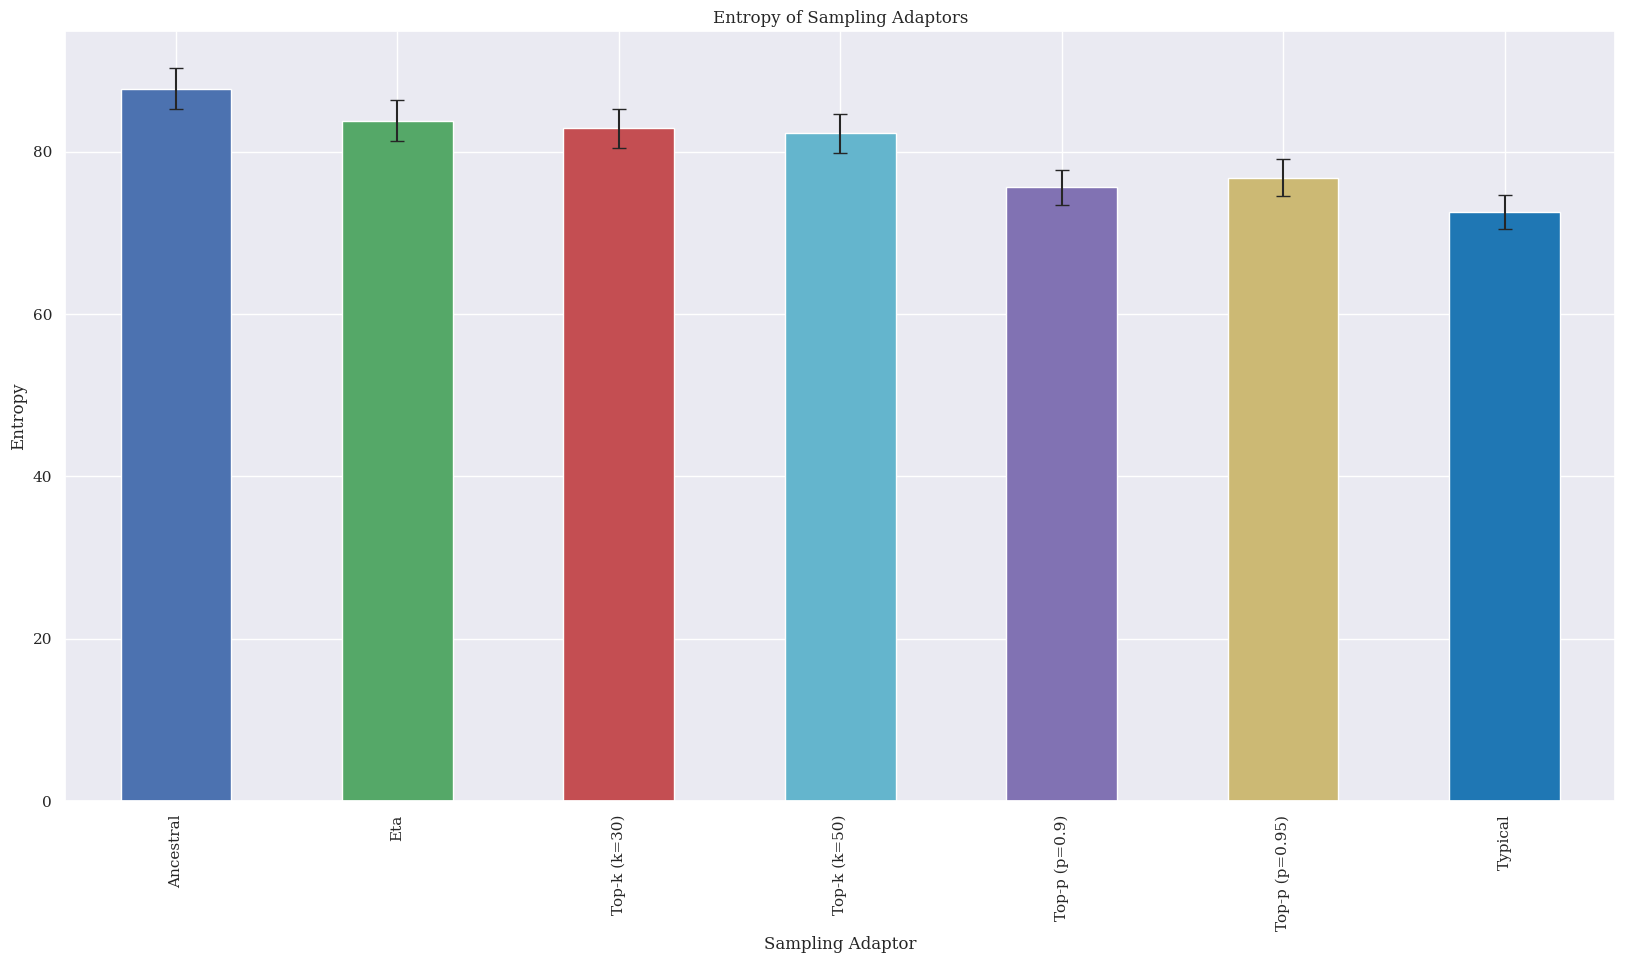

In [27]:
# 4. plot entropies
entropies = dict()  # key -> {entropy, entropy_std}
for idx, (reward_df_file, nll_df_file, correction_df_file) in enumerate(triplet_files):
    # annotation styling
    possible_names = [
        sampling_type
        for sampling_type in sampling_types_to_names.keys()
        if sampling_type in reward_df_file
    ]
    assert len(possible_names) == 1
    sampling_name = possible_names[0]
    assert sampling_name in nll_df_file and sampling_name in correction_df_file
    name = sampling_types_to_names[sampling_name][0]
    marker = "v" if "t1.5" in sampling_name else "x" if "t2.0" in sampling_name else "o"
    colour = sampling_types_to_names[sampling_name][1]

    print(f"\n\nAnalyzing {reward_df_file} and {nll_df_file}:")

    # load and merge
    reward_df = pd.read_csv(f"data/{reward_df_file}")
    nll_df = pd.read_csv(f"data/{nll_df_file}")
    correction_df = pd.read_csv(f"data/{correction_df_file}")

    df = reward_df.merge(nll_df, on=["prompt", "generated_text"], how="inner").merge(
        correction_df, on=["prompt", "generated_text"], how="inner"
    )

    # 3.1.1 get log probability
    df["log_probability"] = -df["negative_log_probability"]

    # 3.1.2 filter duplicates, empty strings, invalid probabilities
    df = df[df.apply(lambda row: len(row["generated_text"]) > 0, axis=1)]
    df = df[df["negative_log_probability"].isin([-np.inf, np.inf]) == False]
    df = df[df["negative_log_probability"].isnull() == False]
    df = df[df["score"].isin([-np.inf, np.inf]) == False]
    df = df[df["score"].isnull() == False]
    df = df.drop_duplicates()
    assert len(df) > 0
    print(f"Length: {len(df)}")
    print(tabulate(df.head(), headers="keys", tablefmt="psql"))
    print("===== Corpus level statistics =====")
    # Sample corpuses
    corpuses = {
        corpus_seed: df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    entropies_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["samplingbiased_negative_log_probability"]].mean(axis=0)
        for corpus_seed, corpus in corpuses.items()
    }).T
    mean_entropy = entropies_df.mean().values[0]
    std_entropy = entropies_df.std().values[0]

    # accumulate for plotting
    entropies[name] = {
        "entropy": mean_entropy,
        "entropy_std": std_entropy,
    }

    print(f"Mean entropy: {mean_entropy}")
    print(f"Std entropy: {std_entropy}")

# bar plot from df
entropy_results_df = pd.DataFrame.from_dict(
    {k: v for k, v in entropies.items() if "t=" not in k}
).T

# plot
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
entropy_results_df.plot.bar(
    y="entropy",
    yerr="entropy_std",
    color=[c for _, c in sampling_types_to_names.values()],
    capsize=5,
    ax=ax,
    ylabel="Entropy",
    xlabel="Sampling Adaptor",
    title="Entropy of Sampling Adaptors",
)

legend_kwargs = {"loc": "lower center", "bbox_to_anchor": (0.5, -0.4), "ncol": 2}
sns.set_theme(font="serif")
plt.legend().remove()
plt.show()
plt.savefig("entropies.png")
plt.close()